In [2]:
import numpy as np
import gym
import time
import math
import random
import torch
from torch.autograd import Variable
from tqdm import tqdm
import copy
from IPython.display import clear_output
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd

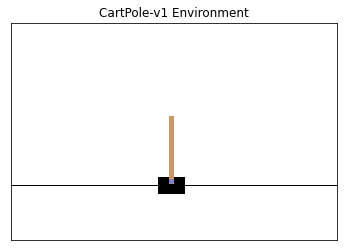

In [3]:
env = gym.envs.make("CartPole-v1")

def get_screen():
    ''' Extract one step of the simulation.'''
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255.
    return torch.from_numpy(screen)

# Speify the number of simulation steps
num_steps = 10

# Show several steps
for i in range(num_steps):
    clear_output(wait=True)
    env.reset()
    plt.figure()
    plt.imshow(get_screen().cpu().permute(1, 2, 0).numpy(),
               interpolation='none')
    plt.title('CartPole-v1 Environment')
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [4]:
observation, reward, done, info = env.step(env.action_space.sample())

In [5]:
print(env.action_space.n)

2


In [6]:
# Demonstration
import matplotlib.pyplot as plt

env = gym.envs.make("CartPole-v1")

def plot_res(values, title=''):   
    ''' Plot the reward curve and histogram of results over time.'''
    # Update the window after each episode
    clear_output(wait=True)
    
    # Define the figure
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
    f.suptitle(title)
    ax[0].plot(values, label='score per run')
    ax[0].axhline(195, c='red',ls='--', label='goal')
    ax[0].set_xlabel('Episodes')
    ax[0].set_ylabel('Reward')
    x = range(len(values))
    ax[0].legend()
    # Calculate the trend
    try:
        z = np.polyfit(x, values, 1)
        p = np.poly1d(z)
        ax[0].plot(x,p(x),"--", label='trend')
    except:
        print('')
    
    # Plot the histogram of results
    ax[1].hist(values[-50:])
    ax[1].axvline(195, c='red', label='goal')
    ax[1].set_xlabel('Scores per Last 50 Episodes')
    ax[1].set_ylabel('Frequency')
    ax[1].legend()
    plt.show()

In [7]:
class DQL():
    ''' Deep Q Neural Network class. '''
    def __init__(self, state_dim, action_dim, hidden_dim=64, lr=0.05):
        self.criterion = torch.nn.MSELoss()
        self.model = torch.nn.Sequential(
                        torch.nn.Linear(state_dim, hidden_dim),
                        torch.nn.LeakyReLU(),
                        torch.nn.Linear(hidden_dim, hidden_dim*2),
                        torch.nn.LeakyReLU(),
                        torch.nn.Linear(hidden_dim*2, action_dim)
                )
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr)
        self.target = copy.deepcopy(self.model)

    def update(self, state, y):
        """Update the weights of the network given a training sample. """
        y_pred = self.model(torch.Tensor(state))
        loss = self.criterion(y_pred, Variable(torch.Tensor(y)))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def predict(self, state):
        """ Compute Q values for all actions using the DQL. """
        with torch.no_grad():
            return self.model(torch.Tensor(state))
        
    def target_predict(self, s):
        ''' Use target network to make predicitons.'''
        with torch.no_grad():
            return self.target(torch.Tensor(s))
        
    def target_update(self):
        ''' Update target network with the model weights.'''
        self.target.load_state_dict(self.model.state_dict())
        
    def replay(self, memory, size, gamma=1.0):
        ''' Add experience replay to the DQL network class.'''
        if len(memory) >= size:
            # Sample experiences from the agent's memory
            data = random.sample(memory, size)
            states = []
            targets = []
            # Extract datapoints from the data
            for state, action, next_state, reward, done in data:
                states.append(state)
                q_values = self.predict(state).tolist()
                if done:
                    q_values[action] = reward
                else:
                    # The only difference between the simple replay is in this line
                    # It ensures that next q values are predicted with the target network.
                    q_values_next = self.target_predict(next_state)
                    q_values[action] = reward + gamma * torch.max(q_values_next).item()

                targets.append(q_values)

            self.update(states, targets)

In [8]:
def q_learning(env, model, episodes, gamma=0.9, epsilon=0.3, eps_decay=0.99, replay=False, replay_size=20, title = 'DQL', double=False, n_update=10, soft=False):
    """Deep Q Learning algorithm using the DQN. """
    final = []
    memory = []
    for episode in range(episodes):
        if double and not soft:
            # Update target network every n_update steps
            if episode % n_update == 0:
                model.target_update()
        if double and soft:
            model.target_update()
        
        # Reset state
        state = env.reset()
        done = False
        total = 0
        
        while not done:
            # Implement greedy search policy
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                q_values = model.predict(state)
                action = torch.argmax(q_values).item()
            
            # Take action and add reward to total
            next_state, reward, done, _ = env.step(action)
            
            # Update total and memory
            total += reward
            memory.append((state, action, next_state, reward, done))
            q_values = model.predict(state).tolist()
             
            if done:
                if not replay:
                    q_values[action] = reward
                    # Update network weights
                    model.update(state, q_values)
                break
                if replay:
                    # Update network weights using replay memory
                    model.replay(memory, replay_size, gamma)
            else: 
                # Update network weights using the last step only
                q_values_next = model.predict(next_state)
                q_values[action] = reward + gamma * torch.max(q_values_next).item()
                model.update(state, q_values)
            state = next_state
        
        # Update epsilon
        epsilon = max(epsilon * eps_decay, 0.01)
        final.append(total)
        plot_res(final, title)
    return final

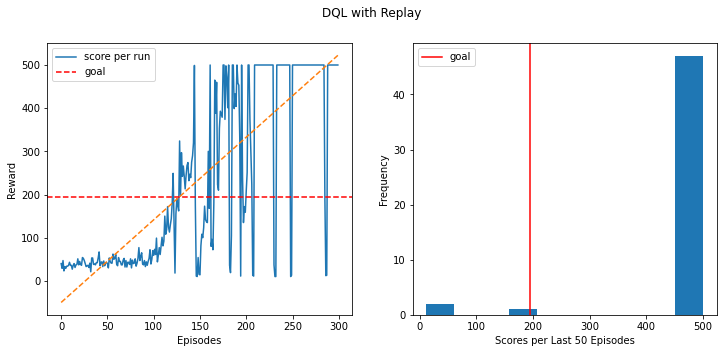

In [122]:
env = gym.envs.make("CartPole-v1")
model = DQL(state_dim=4, action_dim=2, hidden_dim=50, lr=0.001)
final = q_learning(env, model, episodes=300,
                   gamma=1.0, epsilon=0.2, replay=False, double=False,
                   title='DQL with Replay', n_update=20)

In [123]:
state = env.reset()
model.predict(state)

tensor([569.6754, 555.4532])

In [135]:
df = pd.DataFrame()
episodes = 1000
epsilon = 0.1
for i in tqdm(range(episodes)):
    done = False
    state = env.reset()
    t=0
    while not done:
        if random.random() < epsilon:
            action = env.action_space.sample()
        else:
            action = model.predict(state).argmax().item()
        df = df.append({'episode': i, 't': t,'Cart Position': state[0], 'Cart Velocity': state[1], 'Pole Angle': state[2], 'Pole Angular Velocity': state[3], 'A': action}, ignore_index=True)
        state, reward, done, _ = env.step(action)
        t += 1

100%|██████████| 1000/1000 [26:41<00:00,  1.60s/it]


In [9]:
# df.to_csv("/data/localhost/taufiq/export-dir/Cartpole-v1-obs-data.csv", index=False)
df = pd.read_csv("/data/localhost/taufiq/export-dir/Cartpole-v1-obs-data.csv")

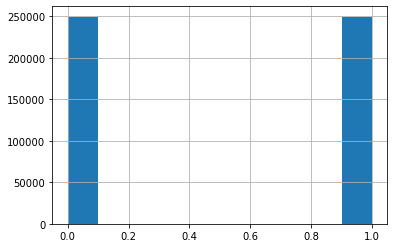

In [10]:
df['A'].hist()

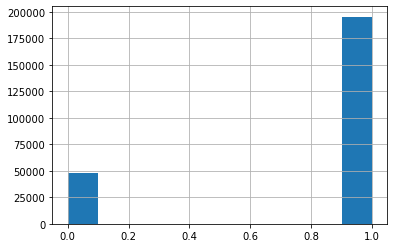

In [11]:
# df.loc[(df['Pole Angular Velocity']>0) & (df['Cart Velocity']>0), 'A'].hist()
df.loc[(df['Pole Angular Velocity']>0), 'A'].hist()

In [12]:
df.head()

,A,Cart Position,Cart Velocity,Pole Angle,Pole Angular Velocity,episode,t
0,0.0,-0.044931,0.005088,0.000109,-0.033541,0.0,0.0
1,1.0,-0.044829,-0.190036,-0.000562,0.259176,0.0,1.0
2,0.0,-0.048630,0.005094,0.004621,-0.033684,0.0,2.0
3,1.0,-0.048528,-0.190094,0.003948,0.260453,0.0,3.0
4,0.0,-0.052330,0.004971,0.009157,-0.030982,0.0,4.0


In [148]:
PATH="/data/localhost/taufiq/export-dir/cartpole/cartpole_state_dicts"
torch.save({
    'model_state_dict': model.model.state_dict(),
    'optimizer_state_dict': model.optimizer.state_dict()
}, PATH)

# Remove the sign of angular velocity

We define the unobserved confounder $U$ to be the sign of Angular velocity

In [13]:
df_partial = df.copy()
df_partial['Pole Angular Velocity (sign)'] = (df_partial['Pole Angular Velocity']>=0)*1 - (df_partial['Pole Angular Velocity']<0)*1
df_partial['Pole Angular Velocity'] = df_partial['Pole Angular Velocity'].abs()
df_partial.rename(columns={'Pole Angular Velocity': 'Pole Angular Velocity (abs)'}, inplace=True)
df_partial.head()


,A,Cart Position,Cart Velocity,Pole Angle,Pole Angular Velocity (abs),episode,t,Pole Angular Velocity (sign)
0,0.0,-0.044931,0.005088,0.000109,0.033541,0.0,0.0,-1
1,1.0,-0.044829,-0.190036,-0.000562,0.259176,0.0,1.0,1
2,0.0,-0.048630,0.005094,0.004621,0.033684,0.0,2.0,-1
3,1.0,-0.048528,-0.190094,0.003948,0.260453,0.0,3.0,1
4,0.0,-0.052330,0.004971,0.009157,0.030982,0.0,4.0,-1


In [14]:
x_columns = ['Cart Position', 'Cart Velocity', 'Pole Angle', 'Pole Angular Velocity (abs)']
rename_cols_t1 = {k: f'{k}_t1' for k in x_columns}

In [15]:
sim_data = pd.DataFrame()
for episode in tqdm(range(0,500)):
    df_filtered_t0 = df_partial.loc[df_partial['episode']==episode].copy().iloc[:-1].reset_index(drop=True)
    df_filtered_t1 = df_partial.loc[df_partial['episode']==episode].copy().iloc[1:][x_columns].rename(columns=rename_cols_t1).reset_index(drop=True)
    df_episode = pd.merge(df_filtered_t0, df_filtered_t1, left_index=True, right_index=True)
    sim_data = sim_data.append(df_episode, ignore_index=True)

100%|██████████| 500/500 [00:04<00:00, 102.09it/s]


In [16]:
obs_data = pd.DataFrame()
for episode in tqdm(range(500,1000)):
    df_filtered_t0 = df_partial.loc[df_partial['episode']==episode].copy().iloc[:-1].reset_index(drop=True)
    df_filtered_t1 = df_partial.loc[df_partial['episode']==episode].copy().iloc[1:][x_columns].rename(columns=rename_cols_t1).reset_index(drop=True)
    df_episode = pd.merge(df_filtered_t0, df_filtered_t1, left_index=True, right_index=True)
    obs_data = obs_data.append(df_episode, ignore_index=True)

100%|██████████| 500/500 [00:03<00:00, 129.84it/s]


In [17]:
len(obs_data)

249500

# Confounding
To induce confounding, we only include transitions with angular velocity > 0, w.p. 0.05 in simulated data.

In [18]:
select = np.random.uniform(0, 1, len(sim_data))
probability = 0.05
sim_data_filtered = sim_data.loc[(sim_data['Pole Angular Velocity (sign)']<=0) | ((sim_data['Pole Angular Velocity (sign)']>0) & (select < probability))].reset_index(drop=True).copy()


In [19]:
len(sim_data_filtered)

134572

In [209]:
random_arr = np.random.uniform(0, 1, len(obs_data))
obs_data_train = obs_data[random_arr <= 0.8].copy()
obs_data_test = obs_data[random_arr > 0.8].copy()

In [20]:
# obs_data_train.to_csv("/data/localhost/taufiq/export-dir/Cartpole-v1-obs-data-train.csv", index=False)
# obs_data_test.to_csv("/data/localhost/taufiq/export-dir/Cartpole-v1-obs-data-test.csv", index=False)

obs_data_train = pd.read_csv("/data/localhost/taufiq/export-dir/Cartpole-v1-obs-data-train.csv")
obs_data_test = pd.read_csv("/data/localhost/taufiq/export-dir/Cartpole-v1-obs-data-test.csv")


In [21]:
(sim_data_filtered['Pole Angular Velocity (sign)']==1).sum()

5995

In [22]:
obs_data_train.head()

,A,Cart Position,Cart Velocity,Pole Angle,Pole Angular Velocity (abs),episode,t,Pole Angular Velocity (sign),Cart Position_t1,Cart Velocity_t1,Pole Angle_t1,Pole Angular Velocity (abs)_t1
0,1.0,0.040271,-0.224381,-0.030521,0.278523,500.0,1.0,1,0.035784,-0.028837,-0.024950,0.023628
1,0.0,0.035784,-0.028837,-0.024950,0.023628,500.0,2.0,-1,0.035207,-0.223592,-0.025423,0.261079
2,0.0,0.035207,-0.223592,-0.025423,0.261079,500.0,3.0,1,0.030735,-0.418342,-0.020201,0.545637
3,1.0,0.022368,-0.222942,-0.009289,0.246658,500.0,5.0,1,0.017909,-0.027689,-0.004355,0.048940
4,0.0,0.017909,-0.027689,-0.004355,0.048940,500.0,6.0,-1,0.017355,-0.222748,-0.005334,0.242365


# Train policy $\pi(A\mid X)$

In [23]:
import torch.utils.data as data_utils

class PolicyNetwork(torch.nn.Module):
    def __init__(self, input_dim, output_dim, hidden_1_dim=3):
        super(PolicyNetwork, self).__init__()
        self.hid1 = torch.nn.Linear(input_dim, hidden_1_dim)
        self.outp = torch.nn.Linear(hidden_1_dim, output_dim)
        self.softmax = torch.nn.Softmax(dim=2)
        self.leaky_relu = torch.nn.LeakyReLU()
        self.tanh = torch.nn.Tanh()

        torch.nn.init.xavier_uniform_(self.hid1.weight)
        torch.nn.init.zeros_(self.hid1.bias)
        torch.nn.init.xavier_uniform_(self.outp.weight)
        torch.nn.init.zeros_(self.outp.bias)

    def forward(self, x):
        z = self.tanh(self.hid1(x))
        z = self.outp(z)
        return z

In [24]:
obs_data_raw = (obs_data_train[x_columns] - df_partial[x_columns].mean())/df_partial[x_columns].std()

In [25]:
grp = np.floor(5*np.random.rand(len(obs_data_train))+1)
crossval = 1
trainidx = (grp != crossval)
testidx = (grp == crossval)
X = torch.FloatTensor(obs_data_raw.loc[trainidx].values)
Xtest = torch.FloatTensor(obs_data_raw.loc[testidx].values)
Y = torch.tensor(obs_data_train.loc[trainidx, 'A'].values).to(torch.long)
Ytest = torch.tensor(obs_data_train.loc[testidx, 'A'].values).to(torch.long)

train = data_utils.TensorDataset(X, Y)
trainloader = torch.utils.data.DataLoader(train, batch_size=32)
test = data_utils.TensorDataset(Xtest, Ytest)
testloader = torch.utils.data.DataLoader(test, batch_size=32)

loss_func = torch.nn.CrossEntropyLoss()
policy = PolicyNetwork(input_dim=len(obs_data_raw.columns), output_dim=2)
optimizer = torch.optim.SGD(policy.parameters(), lr=0.01)
losses = []

In [26]:
for epoch in tqdm(range(200)):
    for data, label in trainloader:
        prediction = policy(data)     # input x and predict based on x
        loss = loss_func(prediction, label)     # must be (1. nn output, 2. target)
        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients
    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            test_loss = 0
            for test_data, test_label in testloader:
                test_loss += loss_func(policy(test_data), test_label)
            losses.append(test_loss.item()/len(testloader))

100%|██████████| 200/200 [05:52<00:00,  1.76s/it]


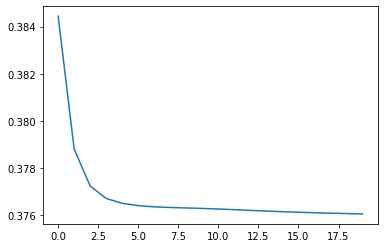

In [27]:
plt.plot(losses)

In [29]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    outputs = policy(Xtest)
    # the class with the highest energy is what we choose as prediction
    _, predicted = torch.max(outputs.data, 1)
    total += Xtest.size(0)
    correct += (predicted == Ytest).sum().item()

print('Accuracy of the policy network: %d %%' % (
    100 * correct / total))

Accuracy of the policy network: 84 %


In [30]:
PATH="/data/localhost/taufiq/export-dir/cartpole/policy_dicts"
torch.save({
    'model_state_dict': policy.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
}, PATH)

# Train $\mathbb{E}[Y \mid x, a]$

In [31]:
outcome = "Pole Angle"

In [32]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data


class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)   # hidden layer
        self.predict = torch.nn.Linear(n_hidden, n_output)   # output layer
        self.tanh = torch.nn.Tanh()

    def forward(self, x):
        x = self.tanh(self.hidden(x))      # activation function for hidden layer
        x = self.predict(x)             # linear output
        return x

In [33]:
grp = np.floor(5*np.random.rand(len(obs_data_train))+1)
crossval = 1
trainidx = (grp != crossval)
testidx = (grp == crossval)
X = torch.FloatTensor(obs_data_raw.loc[trainidx].values)
Xtest = torch.FloatTensor(obs_data_raw.loc[testidx].values)
A = torch.FloatTensor(obs_data_train.loc[trainidx, 'A'].values)
Atest = torch.FloatTensor(obs_data_train.loc[testidx, 'A'].values)

Y = torch.FloatTensor((obs_data_train.loc[trainidx, f'{outcome}_t1'] - df_partial[outcome].mean()).values/df_partial[outcome].std()).unsqueeze(dim=1)
Ytest = torch.FloatTensor((obs_data_train.loc[testidx, f'{outcome}_t1'] - df_partial[outcome].mean()).values/df_partial[outcome].std()).unsqueeze(dim=1)

train = data_utils.TensorDataset(torch.column_stack((X, A)), Y)
trainloader = torch.utils.data.DataLoader(train, batch_size=32)
test = data_utils.TensorDataset(torch.column_stack((Xtest, Atest)), Ytest)
testloader = torch.utils.data.DataLoader(test, batch_size=32)

loss_func = torch.nn.MSELoss()
obs_net = Net(n_feature=len(obs_data_raw.columns)+1, n_hidden=4, n_output=1)
optimizer = torch.optim.SGD(obs_net.parameters(), lr=0.01)
losses = []

In [34]:
for epoch in tqdm(range(100)):
    for X, Y in trainloader:
        prediction = obs_net(X)     # input x and predict based on x

        loss = loss_func(prediction, Y)     # must be (1. nn output, 2. target)

        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients
    with torch.no_grad():
        test_loss = 0
        for Xtest, Ytest in testloader:
            test_loss += loss_func(obs_net(Xtest), Ytest)
        test_loss = test_loss/len(testloader)
        losses.append(test_loss.item())

100%|██████████| 100/100 [03:10<00:00,  1.90s/it]


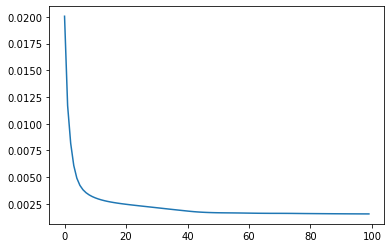

In [35]:
plt.plot(losses)

In [36]:
PATH="/data/localhost/taufiq/export-dir/cartpole/y_obs_dicts"
torch.save({
    'model_state_dict': obs_net.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
}, PATH)

# Train $\mathbb{E}[Y^{sim}(a) \mid x(a)]$

In [37]:
sim_data_raw = (sim_data_filtered[x_columns] - df_partial[x_columns].mean())/df_partial[x_columns].std()

In [38]:
grp = np.floor(5*np.random.rand(len(sim_data_filtered))+1)
crossval = 1
trainidx = (grp != crossval)
testidx = (grp == crossval)
X = torch.FloatTensor(sim_data_raw.loc[trainidx].values)
Xtest = torch.FloatTensor(sim_data_raw.loc[testidx].values)
A = torch.FloatTensor(sim_data_filtered.loc[trainidx, 'A'].values)
Atest = torch.FloatTensor(sim_data_filtered.loc[testidx, 'A'].values)

Y = torch.FloatTensor((sim_data_filtered.loc[trainidx, f'{outcome}_t1'] - df_partial[outcome].mean()).values/df_partial[outcome].std()).unsqueeze(dim=1)
Ytest = torch.FloatTensor((sim_data_filtered.loc[testidx, f'{outcome}_t1'] - df_partial[outcome].mean()).values/df_partial[outcome].std()).unsqueeze(dim=1)

train = data_utils.TensorDataset(torch.column_stack((X, A)), Y)
trainloader = torch.utils.data.DataLoader(train, batch_size=32)
test = data_utils.TensorDataset(torch.column_stack((Xtest, Atest)), Ytest)
testloader = torch.utils.data.DataLoader(test, batch_size=32)

loss_func = torch.nn.MSELoss()
sim_net = Net(n_feature=len(sim_data_raw.columns)+1, n_hidden=4, n_output=1)
optimizer = torch.optim.SGD(sim_net.parameters(), lr=0.01)
losses = []

In [39]:
for epoch in tqdm(range(100)):
    for X, Y in trainloader:
        prediction = sim_net(X)     # input x and predict based on x

        loss = loss_func(prediction, Y)     # must be (1. nn output, 2. target)

        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients
    with torch.no_grad():
        test_loss = 0
        for Xtest, Ytest in testloader:
            test_loss += loss_func(sim_net(Xtest), Ytest)
        test_loss = test_loss/len(testloader)
        losses.append(test_loss.item())

100%|██████████| 100/100 [02:07<00:00,  1.27s/it]


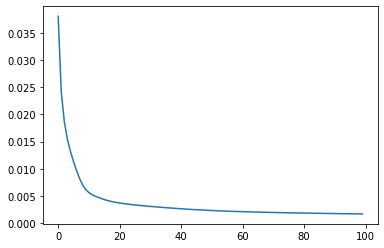

In [40]:
plt.plot(losses)

In [41]:
PATH="/data/localhost/taufiq/export-dir/cartpole/y_sim_dicts"
torch.save({
    'model_state_dict': sim_net.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
}, PATH)

In [42]:
sim_data.head()

,A,Cart Position,Cart Velocity,Pole Angle,Pole Angular Velocity (abs),episode,t,Pole Angular Velocity (sign),Cart Position_t1,Cart Velocity_t1,Pole Angle_t1,Pole Angular Velocity (abs)_t1
0,0.0,-0.044931,0.005088,0.000109,0.033541,0.0,0.0,-1,-0.044829,-0.190036,-0.000562,0.259176
1,1.0,-0.044829,-0.190036,-0.000562,0.259176,0.0,1.0,1,-0.048630,0.005094,0.004621,0.033684
2,0.0,-0.048630,0.005094,0.004621,0.033684,0.0,2.0,-1,-0.048528,-0.190094,0.003948,0.260453
3,1.0,-0.048528,-0.190094,0.003948,0.260453,0.0,3.0,1,-0.052330,0.004971,0.009157,0.030982
4,0.0,-0.052330,0.004971,0.009157,0.030982,0.0,4.0,-1,-0.052230,-0.190281,0.008537,0.264576


# Compare MSE with Scores

In [43]:
obs_data_test = sim_data.copy()
obs_data_test_raw = (obs_data_test[x_columns] - df_partial[x_columns].mean())/df_partial[x_columns].std()

In [44]:
obs_data_test_copy = obs_data_test.copy()
with torch.no_grad():
    X_val = torch.FloatTensor(obs_data_test_raw.values) 
    A_val = torch.FloatTensor(obs_data_test['A'].values)
    pred = obs_net(torch.column_stack((X_val, A_val))).reshape(-1)*df_partial[outcome].std() + df_partial[outcome].mean()
    sim_pred = sim_net(torch.column_stack((X_val, A_val))).reshape(-1)*df_partial[outcome].std() + df_partial[outcome].mean()
    Y = torch.FloatTensor(obs_data_test[f'{outcome}_t1'].values)
    mse = torch.square(sim_pred - Y)
    pol_val = torch.nn.Softmax(dim=1)(policy(X_val))[torch.arange(A_val.shape[0]), A_val.to(torch.long)]
    obs_data_test_copy['MSE'] = mse.numpy()
    obs_data_test_copy['LB'] = (pred*pol_val - (1-pol_val)*0.418).numpy()
    obs_data_test_copy['UB'] = (pred*pol_val + (1-pol_val)*0.418).numpy()
    obs_data_test_copy[f'Sim_{outcome}_t1'] = sim_pred.numpy()
    obs_data_test_copy['In bounds'] = (obs_data_test_copy['LB'] <= obs_data_test_copy[f'Sim_{outcome}_t1']).apply(int) * (obs_data_test_copy['UB'] >= obs_data_test_copy[f'Sim_{outcome}_t1']).apply(int)
    
    

In [45]:
obs_data_test_copy.head()

,A,Cart Position,Cart Velocity,Pole Angle,Pole Angular Velocity (abs),episode,t,Pole Angular Velocity (sign),Cart Position_t1,Cart Velocity_t1,Pole Angle_t1,Pole Angular Velocity (abs)_t1,MSE,LB,UB,Sim_Pole Angle_t1,In bounds
0,0.0,-0.044931,0.005088,0.000109,0.033541,0.0,0.0,-1,-0.044829,-0.190036,-0.000562,0.259176,4.946047e-08,-0.174515,0.174062,-0.000340,1
1,1.0,-0.044829,-0.190036,-0.000562,0.259176,0.0,1.0,1,-0.048630,0.005094,0.004621,0.033684,1.804474e-08,-0.023817,0.032889,0.004756,1
2,0.0,-0.048630,0.005094,0.004621,0.033684,0.0,2.0,-1,-0.048528,-0.190094,0.003948,0.260453,4.404690e-08,-0.292595,0.294966,0.004158,1
3,1.0,-0.048528,-0.190094,0.003948,0.260453,0.0,3.0,1,-0.052330,0.004971,0.009157,0.030982,9.196044e-08,-0.018491,0.035926,0.008853,1
4,0.0,-0.052330,0.004971,0.009157,0.030982,0.0,4.0,-1,-0.052230,-0.190281,0.008537,0.264576,3.950593e-08,-0.319559,0.323441,0.008736,1


In [46]:
obs_data_test_copy.loc[obs_data_test_copy['A']==0, 'MSE'].mean()

4.909186941404187e-07

In [47]:
obs_data_test_copy.loc[obs_data_test_copy['A']==1, 'MSE'].mean()

1.776784642970597e-06

In [48]:
((obs_data_test_copy['In bounds']==1) & (obs_data_test_copy['A']==1)).sum()/(obs_data_test_copy['A']==1).sum()

0.9994198694706309

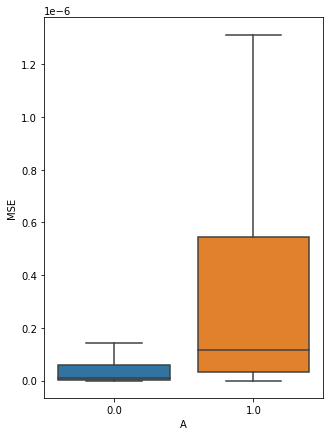

In [49]:
import seaborn as sns
fig, axs = plt.subplots(1, figsize=(5,7))
obs_data_test_copy['A'] = obs_data_test_copy['A'].apply(str)
sns.boxplot(y='MSE',x='A', data=obs_data_test_copy, ax=axs, showfliers=False)

# Simulator 2: wrong model

In [50]:
sim2_data = sim_data.copy()

In [51]:
epsilon = 0.05
sim2_data.loc[sim2_data['A']==1, 'Pole Angle_t1'] -= np.square(np.random.randn((sim2_data['A']==1).sum()))*epsilon

In [53]:
sim2_data.head()

,A,Cart Position,Cart Velocity,Pole Angle,Pole Angular Velocity (abs),episode,t,Pole Angular Velocity (sign),Cart Position_t1,Cart Velocity_t1,Pole Angle_t1,Pole Angular Velocity (abs)_t1
0,0.0,-0.044931,0.005088,0.000109,0.033541,0.0,0.0,-1,-0.044829,-0.190036,-0.000562,0.259176
1,1.0,-0.044829,-0.190036,-0.000562,0.259176,0.0,1.0,1,-0.048630,0.005094,-0.010465,0.033684
2,0.0,-0.048630,0.005094,0.004621,0.033684,0.0,2.0,-1,-0.048528,-0.190094,0.003948,0.260453
3,1.0,-0.048528,-0.190094,0.003948,0.260453,0.0,3.0,1,-0.052330,0.004971,-0.013801,0.030982
4,0.0,-0.052330,0.004971,0.009157,0.030982,0.0,4.0,-1,-0.052230,-0.190281,0.008537,0.264576


# Train $\mathbb{E}[Y^{sim2}(a) \mid x(a)]$

In [ ]:
sim2_data_raw = (sim2_data[x_columns] - df_partial[x_columns].mean())/df_partial[x_columns].std()

In [ ]:
grp = np.floor(5*np.random.rand(len(sim2_data))+1)
crossval = 1
trainidx = (grp != crossval)
testidx = (grp == crossval)
X = torch.FloatTensor(sim2_data_raw.loc[trainidx].values)
Xtest = torch.FloatTensor(sim2_data_raw.loc[testidx].values)
A = torch.FloatTensor(sim2_data.loc[trainidx, 'A'].values)
Atest = torch.FloatTensor(sim2_data.loc[testidx, 'A'].values)

Y = torch.FloatTensor((sim2_data.loc[trainidx, f'{outcome}_t1'] - df_partial[outcome].mean()).values/df_partial[outcome].std()).unsqueeze(dim=1)
Ytest = torch.FloatTensor((sim2_data.loc[testidx, f'{outcome}_t1'] - df_partial[outcome].mean()).values/df_partial[outcome].std()).unsqueeze(dim=1)

train = data_utils.TensorDataset(torch.column_stack((X, A)), Y)
trainloader = torch.utils.data.DataLoader(train, batch_size=32)
test = data_utils.TensorDataset(torch.column_stack((Xtest, Atest)), Ytest)
testloader = torch.utils.data.DataLoader(test, batch_size=32)

loss_func = torch.nn.MSELoss()
sim2_net = Net(n_feature=len(sim2_data_raw.columns)+1, n_hidden=4, n_output=1)
optimizer = torch.optim.SGD(sim2_net.parameters(), lr=0.01)
losses = []

In [ ]:
for epoch in tqdm(range(100)):
    for X, Y in trainloader:
        prediction = sim2_net(X)     # input x and predict based on x

        loss = loss_func(prediction, Y)     # must be (1. nn output, 2. target)

        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients
    with torch.no_grad():
        test_loss = 0
        for Xtest, Ytest in testloader:
            test_loss += loss_func(sim2_net(Xtest), Ytest)
        test_loss = test_loss/len(testloader)
        losses.append(test_loss.item())

In [ ]:
plt.plot(losses)